# ***Kaggle:*** Chess Evaluations

| Author's Name         | NIU     |
| --------------------- | ------- |
| Albert Capdevila      | 1587933 |

<small>*This Jupyter Notebook is submitted as an assignment for the Machine Learning subject in the Computer Engineering degree at the Universitat Autònoma de Barcelona (UAB).*<small>

## 1. Problem definition

In computer chess, an evaluation function estimates the strength of a position by assigning a numerical score that indicates which side (White or Black) has the advantage and by how much.

This score is based on the values of chess pieces, which are traditionally:
| Piece  | Pawn | Knight | Bishop | Rook | Queen |
|--------|------|--------|--------|------|-------|
| Symbol | ![Pawn](https://upload.wikimedia.org/wikipedia/commons/thumb/4/45/Chess_plt45.svg/45px-Chess_plt45.svg.png) | ![Knight](https://upload.wikimedia.org/wikipedia/commons/thumb/7/70/Chess_nlt45.svg/45px-Chess_nlt45.svg.png) | ![Bishop](https://upload.wikimedia.org/wikipedia/commons/thumb/b/b1/Chess_blt45.svg/45px-Chess_blt45.svg.png) | ![Rook](https://upload.wikimedia.org/wikipedia/commons/thumb/7/72/Chess_rlt45.svg/45px-Chess_rlt45.svg.png) | ![Queen](https://upload.wikimedia.org/wikipedia/commons/thumb/1/15/Chess_qlt45.svg/45px-Chess_qlt45.svg.png) |
| Value  | 1    | 3      | 3      | 5    | 9     |

<small>*The value of the king is undefined as it cannot be captured, let alone traded, during the course of the game. Chess engines usually assign the king an arbitrary large value such as 200 points [¹](#references).*</small>

These values show that, for example, capturing a bishop is equivalent to capturing three pawns. Therefore, all of them can be expressed in *'pawn units'*.

It’s also important to note that evaluations are opposite, with positive values indicating an advantage for White and negative values for Black. For example, a negative evaluation of $-3$ pawns may indicate that Black has an advantage equivalent to three pawns, a bishop, or a knight.

Usually, these evaluations are calculated by complex algorithms, such as *Stockfish*, which are based on **minimax** principles, calculating, pruning, and predicting the best moves across multiple levels of depth. These algorithms can be slow and computationally intensive, as they analyze many possible future moves in a position. This notebook will explore the use of regression models to achieve similar results more quickly.

***In this notebook, we aim to estimate the evaluation score of a chess position through feature extraction and simple regression techniques.***



## 2. Data collection

For this machine learning problem, we will use the **Chess Evaluations** dataset, available [here](https://www.kaggle.com/datasets/ronakbadhe/chess-evaluations/data) on Kaggle. The dataset contains two columns: 

| Feature             | Description                                                                 |
|---------------------|-----------------------------------------------------------------------------|
| **Position (FEN)**  | This is a string representing the chess position in Forsyth-Edwards Notation (FEN). |
| **Evaluation**      | This is the evaluation of the position in ***centipawns***. `#` means that there is forced checkmate. |

The evaluations are in centi-pawns and are generated from Stockfish 11 at depth 22.

Let’s download and import the dataset:

In [1]:

from kaggle.api.kaggle_api_extended import KaggleApi
from zipfile import ZipFile
from tqdm import tqdm
import pandas as pd
import numpy as np
import re
import os 

api = KaggleApi()
api.authenticate()

dataser_owner = 'ronakbadhe'
dataset_name= 'chess-evaluations'
dataset = f'{dataser_owner}/{dataset_name}'
target = 'Evaluation'

if not os.path.isdir('data'):
  print("The 'data' directory was not found")
  print("Downloading the dataset from Kaggle...")
  os.mkdir('data')
  api.dataset_download_files(dataset = dataset,path = 'data')
  zf = ZipFile(f'data/{dataset_name}.zip')
  zf.extractall(f'data')
  zf.close()
  os.remove(f'data/{dataset_name}.zip')
  print("Dataset downloaded successfully ✓")
else:
  print("The 'data' directory was found successfully ✓")

The 'data' directory was found successfully ✓


In [2]:
csvFile = "chessData.csv"
print(f"Reading the file '{csvFile}'...")

df = pd.read_csv(f'data/{csvFile}')

print(f"File '{csvFile}' read successfully ✓")

Reading the file 'chessData.csv'...
File 'chessData.csv' read successfully ✓


In [3]:
# Reducing the dataset size to make it faster to work with
from sklearn.model_selection import train_test_split

_, df = train_test_split(df, test_size=0.01, random_state=42)

In [4]:
df.head()

,FEN,Evaluation
11784899,r3k2r/1b2bppp/p1n1pn2/1p2N1B1/8/2NB1P2/PPP3PP/...,-35
8860705,r3k2r/1pp2p2/1bnp1q2/p2Bp1p1/PP2P1bP/1QPP1N2/3...,-201
7376649,6k1/2p3pp/8/8/P3R3/3r1PP1/5K1P/8 b - - 0 30,+121
2224083,1r6/2rnppkp/1q1p2n1/2pP2p1/2b5/1P4PP/P1QNPPB1/...,+280
4108821,5k2/3R4/1p1p4/3n2pp/8/8/PP6/6K1 b - - 1 35,+328


## 3. Data preprocessing

### 3.1 Missing Data

In [5]:
df.isna().sum()

FEN           0
Evaluation    0
dtype: int64

Since there are no missing values, there is no need to handle NaN values.

### 3.2 Data Conversion

In [6]:
df.dtypes

FEN           object
Evaluation    object
dtype: object

The evaluation feature is a string that starts with either a "+" or "-" symbol. To use it in the model, it will need to be converted into a numeric value.

It may also include the character `#`, but since this is not relevant to the current problem, we will ignore it.

In [7]:
tqdm.pandas(desc="Converting 'Evaluation' to numeric values")
df['Evaluation'] = df['Evaluation'].progress_apply(lambda x: int(x) if '#' not in x else int(x.replace('#', '')))

Converting 'Evaluation' to numeric values: 100%|██████████| 129581/129581 [00:00<00:00, 578498.98it/s]


In [8]:
df.dtypes

FEN           object
Evaluation     int64
dtype: object

### 3.3 Data Normalization

Apart from the target feature (Evaluation), the dataset contains only one feature: FEN, which cannot be normalized. Therefore, normalization is not applicable in this case.

### 3.4 Feature extraction

In this section, we will focus on feature extraction, which is the most important step in building our model to predict the evaluation of a chess position. At the moment, we only have the FEN notation of the chess position, and our goal is to extract useful features from it.

#### 3.4.1 Information in the FEN Notation

Forsyth–Edwards Notation (FEN) is a standard notation for describing a particular board position of a chess game.

A typical FEN string looks like this: `rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR b KQkq e3 0 1`

The FEN string above represents the following board position:

<img src="img/example_board.svg" alt="Example Board" width="300"/>

A FEN string has six fields, each separated by a space:

1. **Piece placement data:**

    It is the arrangement of pieces on the board, row by row, from top to bottom. Each piece is represented by a letter (uppercase for White and lowercase for Black). Empty squares are indicated by numbers.

2. **Active color:**

    Indicates which side is to move (`w` for White, `b` for Black).

3. **Castling availability:**

    If no castling is possible, this field is `-`. Otherwise, it shows `K`, `Q`, `k`, or `q` for available castling options.

4. **En passant target square:**

    Indicates the square where an en passant capture is possible, or `-` if not.

5. **Halfmove clock:**

    Counts the number of halfmoves since the last pawn advance or capture, used for the 50-move rule. 

6. **Fullmove number:**

    Tracks the total number of moves in the game, starting at 1 and incrementing after each Black move.

Only using this information, we can start extracting some simple new features:

In [69]:
try:
    answ = input("Would you like to the preprocessing? It might take a bit long Y/N")
    if answ.upper() == 'N':
        raise Exception("Exited successfully")

except Exception as e:
    print(e)

<small>*(Alternatively, if you’ve already performed the preprocessing, you can load the data [here](#import-data))*</small>

In [70]:
def count_white_pieces(fen):
    return len(re.findall(r'[KQRBNP]', fen))

def count_black_pieces(fen):
    return len(re.findall(r'[kqrbnp]', fen))

tqdm.pandas(desc="Adding column 'White_pieces_count'")
df['White_pieces_count'] = df['FEN'].progress_apply(count_white_pieces)
tqdm.pandas(desc="Adding column 'Black_pieces_count'")
df['Black_pieces_count'] = df['FEN'].progress_apply(count_black_pieces)

Adding column 'Black_pieces_count': 100%|██████████| 129581/129581 [00:00<00:00, 168072.30it/s]


In [71]:
piece_values = {
    'P': 1, 'N': 3, 'B': 3, 'R': 5, 'Q': 9, 'K' : 200,
    'p': -1, 'n': -3, 'b': -3, 'r': -5, 'q': -9, 'k' : -200,
    ' ' : 0
}

# The king's value is ignored for now.

def get_white_material(fen):
    return sum(piece_values[piece] for piece in re.findall(r'[QRBNP]', fen))

def get_black_material(fen):
    return -sum(piece_values[piece] for piece in re.findall(r'[qrbnp]', fen))

tqdm.pandas(desc="Adding column 'White_material'")
df['White_material'] = df['FEN'].progress_apply(get_white_material)

tqdm.pandas(desc="Adding column 'Black_material'")
df['Black_material'] = df['FEN'].progress_apply(get_black_material)

df["Material_difference"] = df['White_material'] - df['Black_material']
print("Added column 'Material_difference' ✓")

Adding column 'Black_material': 100%|██████████| 129581/129581 [00:00<00:00, 139783.56it/s]

Added column 'Material_difference' ✓


In [72]:
def get_turn(fen):
    return 1 if fen.split(' ')[1] == 'w' else -1

tqdm.pandas(desc="Adding column 'Turn'")
df['Turn'] = df['FEN'].progress_apply(get_turn)

Adding column 'Turn': 100%|██████████| 129581/129581 [00:00<00:00, 543439.61it/s]


In [73]:
def get_castling(fen, char):
    return int(char in fen.split(' ')[2])

tqdm.pandas(desc="Adding column 'White_king_castling'")
df['White_king_castling'] = df['FEN'].progress_apply(lambda fen: get_castling(fen, 'K'))

tqdm.pandas(desc="Adding column 'White_queen_castling'")
df['White_queen_castling'] = df['FEN'].progress_apply(lambda fen: get_castling(fen, 'Q'))

tqdm.pandas(desc="Adding column 'Black_king_castling'")
df['Black_king_castling'] = df['FEN'].progress_apply(lambda fen: get_castling(fen, 'k'))

tqdm.pandas(desc="Adding column 'Black_queen_castling'")
df['Black_queen_castling'] = df['FEN'].progress_apply(lambda fen: get_castling(fen, 'q'))

df['Castling_difference'] = df['White_king_castling'] + df['White_queen_castling'] - df['Black_king_castling'] - df['Black_queen_castling']
print("Added column 'Castling_difference' ✓")


Adding column 'Black_queen_castling': 100%|██████████| 129581/129581 [00:00<00:00, 504202.08it/s]

Added column 'Castling_difference' ✓


In [74]:
def get_en_passant(fen):
    # This feature is 1 if en passant is available for White, -1 for Black, and 0 if none
    return int(fen.split(' ')[3] != '-') * 1 if fen.split(' ')[1] == 'w' else -1

tqdm.pandas(desc="Adding column 'En_passant'")
df['En_passant'] = df['FEN'].progress_apply(get_en_passant)

Adding column 'En_passant': 100%|██████████| 129581/129581 [00:00<00:00, 456193.51it/s]


In [75]:
def get_rule50(fen):
    return int(fen.split(' ')[4]) * 1 if fen.split(' ')[1] == 'w' else -1

tqdm.pandas(desc="Adding column 'Rule_50'")
df['Rule_50'] = df['FEN'].progress_apply(get_rule50)

Adding column 'Rule_50': 100%|██████████| 129581/129581 [00:00<00:00, 492624.80it/s]


In [76]:
def get_n_moves(fen):
    return int(fen.split(' ')[5]) + int(fen.split(' ')[1] == 'b')

tqdm.pandas(desc="Adding column 'N_moves'")
df['N_moves'] = df['FEN'].progress_apply(get_n_moves)

Adding column 'N_moves': 100%|██████████| 129581/129581 [00:00<00:00, 426273.82it/s]


Let's see the correlations between the new features and the target variable:

In [77]:
correlations = df.corr(numeric_only=True)['Evaluation']
sorted_correlations = correlations.reindex(correlations.abs().sort_values(ascending=False).index)
print("Correlations with 'Evaluation' (sorted by absolute value):")
print(sorted_correlations)

Correlations with 'Evaluation' (sorted by absolute value):
Evaluation              1.000000
Material_difference     0.196688
White_pieces_count      0.042156
Black_pieces_count     -0.041349
White_material          0.031842
Black_material         -0.022179
En_passant              0.021284
Turn                    0.021133
Rule_50                 0.013880
White_king_castling    -0.003880
Black_king_castling    -0.002919
Black_queen_castling   -0.002685
N_moves                 0.002614
White_queen_castling   -0.002510
Castling_difference    -0.000297
Name: Evaluation, dtype: float64


There are no significant correlations.

#### 3.4.2 Information from the Game Position (General)

Currently, we only extract information from the FEN string, not from the position itself (for instance, two positions with the same pieces, turn, en passant, and number of moves would appear identical to the model).

We need to extract information directly from the game. To achieve this, we'll use the chess library to obtain a board representation and apply some of its functions to build new features.

In [78]:
%pip install chess
import chess

Note: you may need to restart the kernel to use updated packages.


In [79]:
def get_board(fen):
    return chess.Board(fen)

tqdm.pandas(desc="Adding column 'Board'")
df['Board'] = df['FEN'].progress_apply(get_board)

Adding column 'Board': 100%|██████████| 129581/129581 [00:12<00:00, 10244.91it/s]


Here are a few features I think could have a strong correlation with the evaluation:

* **Attack count:**
    It is the number of squares attacked by each individual piece of a player. If a square is attacked by more than one piece, it is counted multiple times.

In [80]:
def get_attacks_count(board, color):
    return sum(len(board.attackers(color, square)) for square in chess.SQUARES)

tqdm.pandas(desc="Adding column 'White_attacks'")
df['White_attacks'] = df['Board'].progress_apply(lambda board: get_attacks_count(board, chess.WHITE))

tqdm.pandas(desc="Adding column 'Black_attacks'")
df['Black_attacks'] = df['Board'].progress_apply(lambda board: get_attacks_count(board, chess.BLACK))

df["Attacks_difference"] = df['White_attacks'] - df['Black_attacks']
print("Added column 'Attacks_difference' ✓")

Adding column 'Black_attacks': 100%|██████████| 129581/129581 [00:24<00:00, 5354.55it/s]

Added column 'Attacks_difference' ✓


* **Central attack count**: It is the number of attacks on the central squares (d4, e4, d5, e5) by each individual piece of a player. If a square is attacked by more than one piece, it is counted multiple times. The central squares are often key in chess, as controlling them typically gives strategic advantages.

In [81]:
def get_central_attacks_count(board, color):
    central_squares = [chess.D4, chess.E4, chess.D5, chess.E5]
    return sum(len(board.attackers(color, square)) for square in central_squares)

tqdm.pandas(desc="Adding column 'White_central_attacks'")
df['White_central_attacks'] = df['Board'].progress_apply(lambda board: get_central_attacks_count(board, chess.WHITE))

tqdm.pandas(desc="Adding column 'Black_central_attacks'")
df['Black_central_attacks'] = df['Board'].progress_apply(lambda board: get_central_attacks_count(board, chess.BLACK))
df["Central_attacks_difference"] = df['White_central_attacks'] - df['Black_central_attacks']
print("Added column 'Central_attacks_difference' ✓")

Adding column 'Black_central_attacks': 100%|██████████| 129581/129581 [00:01<00:00, 65910.97it/s]

Added column 'Central_attacks_difference' ✓


* **Legal moves:**
    It is the total number of legal moves available for a player in the current position.

In [82]:
def get_legal_moves(board, color):
    orig_turn = board.turn 
    board.turn = color
    legal_moves = len(list(board.legal_moves))
    board.turn = orig_turn
    return legal_moves

tqdm.pandas(desc="Adding column 'White_legal_moves'")
df['White_legal_moves'] = df['Board'].progress_apply(lambda board: get_legal_moves(board, chess.WHITE))

tqdm.pandas(desc="Adding column 'Black_legal_moves'")
df['Black_legal_moves'] = df['Board'].progress_apply(lambda board: get_legal_moves(board, chess.BLACK))

df["Legal_moves_difference"] = df['White_legal_moves'] - df['Black_legal_moves']
print("Added column 'Legal_moves_difference' ✓")

Adding column 'Black_legal_moves': 100%|██████████| 129581/129581 [00:11<00:00, 11349.77it/s]

Added column 'Legal_moves_difference' ✓


* **Attacked pieces**:
    It is the total number of opponent attacks on squares occupied by a player's pieces.

In [83]:
def get_attacked_pieces(board, color):
    attacked_pieces = 0
    opponent_color = chess.WHITE if color == chess.BLACK else chess.BLACK 
    for square in chess.SQUARES:
        piece = board.piece_at(square)
        if piece and piece.color == color:
            attacked_pieces += len(board.attackers(opponent_color, square))

    return attacked_pieces

tqdm.pandas(desc="Adding column 'White_attacked'")
df['White_attacked'] = df['Board'].progress_apply(lambda board: get_attacked_pieces(board, chess.WHITE))
tqdm.pandas(desc="Adding column 'Black_attacked'")
df['Black_attacked'] = df['Board'].progress_apply(lambda board: get_attacked_pieces(board, chess.BLACK))

df["Attacked_difference"] = df['Black_attacked'] - df['White_attacked']
print("Added column 'Attacked_difference' ✓")

Adding column 'Black_attacked': 100%|██████████| 129581/129581 [00:10<00:00, 12936.14it/s]

Added column 'Attacked_difference' ✓


- **Check:** Verifies if a player's king is under attack

In [84]:
def get_check(board):
    return int(board.is_check()) * 1 if board.turn else -1

tqdm.pandas(desc="Adding column 'Check'")
df['Check'] = df['Board'].progress_apply(get_check)

Adding column 'Check': 100%|██████████| 129581/129581 [00:00<00:00, 351131.08it/s]


<small>*"In chess, doubled pawns are two pawns of the same color residing on the same file. Pawns can become doubled only when one pawn captures onto a file on which another friendly pawn resides. [...] In most cases, doubled pawns are considered a weakness due to their inability to defend each other." [²](#references)*</small>


* **Doubled pawns**: It is the count of how many extra pawns are stacked in each file for a player

In [85]:
def count_doubled_pawns(board, color):
    doubled_pawns = 0
    for file in chess.FILE_NAMES:
        column_squares = [chess.square(chess.FILE_NAMES.index(file), rank) for rank in range(8)]
        pawns_in_file = sum(1 for square in column_squares if board.piece_at(square) == chess.Piece(chess.PAWN, color))
        if pawns_in_file > 1:
            doubled_pawns += pawns_in_file - 1
    return doubled_pawns

tqdm.pandas(desc="Adding column 'White_doubled_pawns'")
df['White_doubled_pawns'] = df['Board'].progress_apply(lambda board: count_doubled_pawns(board, chess.WHITE))
tqdm.pandas(desc="Adding column 'Black_doubled_pawns'")
df['Black_doubled_pawns'] = df['Board'].progress_apply(lambda board: count_doubled_pawns(board, chess.BLACK))

df["Doubled_pawns_difference"] = df['White_doubled_pawns'] - df['Black_doubled_pawns']
print("Added column 'Doubled_pawns_difference' ✓")

Adding column 'Black_doubled_pawns': 100%|██████████| 129581/129581 [00:16<00:00, 7824.68it/s]

Added column 'Doubled_pawns_difference' ✓


<small>*"In chess, a fork is a tactic in which a piece attacks multiple enemy pieces simultaneously. The attacker usually aims to capture one of the forked pieces" [³](#references)*</small>

- **Forks:** Counts the number of forks for each player.

In [86]:
def get_forks(board, color):
    forks = 0
    for square, piece in board.piece_map().items():
        if piece.color == color:
            attacked_squares = board.attacks(square)
            if len([target for target in attacked_squares if board.piece_at(target) and board.piece_at(target).color != color]) > 1:
                forks += 1

    return forks

tqdm.pandas(desc="Adding column 'White_forks'")
df['White_forks'] = df['Board'].progress_apply(lambda board: get_forks(board, chess.WHITE))
tqdm.pandas(desc="Adding column 'Black_forks'")
df['Black_forks'] = df['Board'].progress_apply(lambda board: get_forks(board, chess.BLACK))

df["Forks_difference"] = df['White_forks'] - df['Black_forks']
print("Added column 'Forks_difference' ✓")

Adding column 'Black_forks': 100%|██████████| 129581/129581 [00:15<00:00, 8291.57it/s]

Added column 'Forks_difference' ✓


*<small>"An open file in chess is a file with no pawns of either color on it. [...] Having rooks or queens on open files or half-open files is considered advantageous, as it allows a player to attack more easily" [⁴](#references)</small>*

* **Open File Control**: Counts the number of open files controlled by each player.

In [87]:
def open_file_control(board, color):
    open_files = 0
    for file in range(8):
        squares = [chess.square(file, rank) for rank in range(8)]
        if all(board.piece_at(square) is None or board.piece_at(square).color == color and board.piece_at(square).piece_type != chess.PAWN for square in squares):
            open_files += 1
    return open_files

tqdm.pandas(desc="Adding column 'White_open_files'")
df['White_open_files'] = df['Board'].progress_apply(lambda board: open_file_control(board, chess.WHITE))
tqdm.pandas(desc="Adding column 'Black_open_files'")
df['Black_open_files'] = df['Board'].progress_apply(lambda board: open_file_control(board, chess.BLACK))

df['Open_files_difference'] = df['White_open_files'] - df['Black_open_files']
print("Added column 'Open_files_difference' ✓")

Adding column 'Black_open_files': 100%|██████████| 129581/129581 [00:07<00:00, 18479.89it/s]

Added column 'Open_files_difference' ✓


* **Major Control**: Calculates the total number of squares controlled by rooks and queens for each player.

In [88]:
def count_major_control(board, color):
    major_pieces = board.pieces(chess.ROOK, color) | board.pieces(chess.QUEEN, color)
    return sum(len(board.attacks(square)) for square in major_pieces)

tqdm.pandas(desc="Adding column 'White_major_control'")
df['White_major_control'] = df['Board'].progress_apply(lambda board: count_major_control(board, chess.WHITE))

tqdm.pandas(desc="Adding column 'Black_major_control'")
df['Black_major_control'] = df['Board'].progress_apply(lambda board: count_major_control(board, chess.BLACK))

df['Major_control_difference'] = df['White_major_control'] - df['Black_major_control']
print("Added column 'Major_control_difference' ✓")

Adding column 'Black_major_control': 100%|██████████| 129581/129581 [00:01<00:00, 84968.58it/s]

Added column 'Major_control_difference' ✓


* **Sixth-Rank Pawns**: Counts the number of pawns for each player positioned on the sixth rank. These become significantly more powerful as they are closer to promotion.

In [89]:
def count_sixth_rank_pawns(fen, color):
    rows = fen.split()[0].split("/")
    rank_index = 2 if color == chess.WHITE else 5
    rank = rows[rank_index]
    
    pawn_char = 'P' if color == chess.WHITE else 'p'
    return rank.count(pawn_char)

tqdm.pandas(desc="Adding column 'White_sixth_rank_pawns'")
df['White_sixth_rank_pawns'] = df['FEN'].progress_apply(lambda fen: count_sixth_rank_pawns(fen, chess.WHITE))

tqdm.pandas(desc="Adding column 'Black_sixth_rank_pawns'")
df['Black_sixth_rank_pawns'] = df['FEN'].progress_apply(lambda fen: count_sixth_rank_pawns(fen, chess.BLACK))

df['Sixth_rank_pawns_difference'] = df['White_sixth_rank_pawns'] - df['Black_sixth_rank_pawns']
print("Added column 'Sixth_rank_pawns_difference' ✓")

Adding column 'Black_sixth_rank_pawns': 100%|██████████| 129581/129581 [00:00<00:00, 348338.05it/s]

Added column 'Sixth_rank_pawns_difference' ✓


Let's see the current strongest correlations: 

In [90]:
correlations = df.corr(numeric_only=True)['Evaluation']
sorted_correlations = correlations.reindex(correlations.abs().sort_values(ascending=False).index)
print("Correlations with 'Evaluation' (sorted by absolute value):")
print(sorted_correlations)

Correlations with 'Evaluation' (sorted by absolute value):
Evaluation                     1.000000
Attacks_difference             0.231071
Material_difference            0.196688
Legal_moves_difference         0.183779
Major_control_difference       0.131955
Sixth_rank_pawns_difference    0.129983
Central_attacks_difference     0.104812
White_legal_moves              0.094974
White_sixth_rank_pawns         0.090383
Black_sixth_rank_pawns        -0.090149
Black_legal_moves             -0.089869
White_attacks                  0.064895
Black_central_attacks         -0.064887
Open_files_difference          0.062926
Black_attacks                 -0.057381
White_major_control            0.055943
White_central_attacks          0.054349
White_pieces_count             0.042156
Black_pieces_count            -0.041349
Black_major_control           -0.034771
White_material                 0.031842
Black_attacked                 0.027091
White_forks                    0.026275
Forks_difference     

Using the chess library, we can extract much more information, but we must keep it simple.  

So far, we have focused on attributes that indicate whether a position might be better, but we have ignored the fact that the goal is to infer a specific value: the evaluation provided by Stockfish 11 at 22 levels of depth (considering 22 turns ahead).  

Therefore, we need to identify the features that Stockfish use to generate their evaluations.

#### 3.4.3 Information that Stockfish uses (Simplified)

Stockfish's evaluation function is actually quite complex and uses lots of values to determine its result. We'll focus on the main ones and simplify where needed:

- Middle game evaluation

    - **Piece Value (eg)**: Material is weighted differently during the middlegame.

    - **Psqt (eg)**: Piece-square table bonuses, where certain positions provide an advantage for specific pieces in the middlegame.

    - Pawns:
        - Doubled: *(Simplified: Already considered in 'Double_pawns')*

    - Pieces:
        - **Minor behind pawn**: Knight or bishop when behind a pawn
        - **Bishop pawns**: Number of pawns on the same color square as the bishop *(Simplified)*
        - **Bishop xray pawns**: Advantatge for every opponent pawn in the diagonal of a bishop
        - **Rook on queen file**: Simple bonus for a rook that is on the same file as any queen
        - **Rook on file**: Rook when on an open file *(Simplified)*
        - **Long diagonal bishop**: Bonus for bishop on a long diagonal which can "see" both center squares.

    - Mobility: *(Simplified: Already considered in 'Legal_moves')*

    - Threats
        - **Hanging**: Weak enemies not defended by opponent *(Simplified)*

    - **Passed**: Bonuses for passed pawns *(Simplified)*

    - **King**: Bonuses for player's pieces around the king *(Simplified)* 

- End game evaluation

    - **Piece Value (EG)**: Material is weighted differently during the endgame.

    - **Psqt (EG)**: Piece-square table bonuses, where certain positions provide an advantage for specific pieces in the endgame.

    It also takes all the above into account, with different weights *(Will be ignored for simplicity)*

- **Phase**: Eval based on the amount of non-pawn material on the board *(Simplified)*

- Rule50: *(Already considered in 'Rule_50')*

- Scale factor: The scale factors are used to scale the endgame evaluation score down *(It will also be ignored)*

- Tempo: *(Already considered in 'Turn')*

<small>*All the bold titles represent new attributes that will be added.*</small>

In [91]:
# This board representation will be used to do calculations quicker

def fen_to_numpy(fen):
    rows = fen.split(' ')[0].split('/')
    np_board = np.full((8, 8), ' ', dtype=str)
    for i, row in enumerate(rows):
        col = 0
        for char in row:
            if char.isdigit():
                col += int(char)
            else:
                np_board[i, col] = char
                col += 1
                
    return np_board

tqdm.pandas(desc="Adding column 'Numpy_board'")
df['Numpy_board'] = df['FEN'].progress_apply(fen_to_numpy)

Adding column 'Numpy_board': 100%|██████████| 129581/129581 [00:02<00:00, 43198.89it/s]


In [92]:
piece_values_mg = {
    'P': 124, 'N': 781, 'B': 825, 'R': 1276, 'Q': 2538,
    'p': -124, 'n': -781, 'b': -825, 'r': -1276, 'q': -2538
}

def get_white_material_mg(fen):
    return sum(piece_values_mg[piece] for piece in re.findall(r'[QRBNP]', fen))

def get_black_material_mg(fen):
    return -sum(piece_values_mg[piece] for piece in re.findall(r'[qrbnp]', fen))

tqdm.pandas(desc="Adding column 'White_material_mg'")
df['White_material_mg'] = df['FEN'].progress_apply(get_white_material_mg)

tqdm.pandas(desc="Adding column 'Black_material_mg'")
df['Black_material_mg'] = df['FEN'].progress_apply(get_black_material_mg)

df["Material_mg_difference"] = df['White_material_mg'] - df['Black_material_mg']
print("Added column 'Material_mg_difference' ✓")

Adding column 'Black_material_mg': 100%|██████████| 129581/129581 [00:00<00:00, 139030.94it/s]

Added column 'Material_mg_difference' ✓


In [93]:
piece_values_eg = {
    'P': 206, 'N': 854, 'B': 915, 'R': 1380, 'Q': 2682,
    'p': -206, 'n': -854, 'b': -915, 'r': -1380, 'q': -2682
}

def get_white_material_eg(fen):
    return sum(piece_values_eg[piece] for piece in re.findall(r'[QRBNP]', fen))

def get_black_material_eg(fen):
    return -sum(piece_values_eg[piece] for piece in re.findall(r'[qrbnp]', fen))

tqdm.pandas(desc="Adding column 'White_material_eg'")
df['White_material_eg'] = df['FEN'].progress_apply(get_white_material_eg)

tqdm.pandas(desc="Adding column 'Black_material_eg'")
df['Black_material_eg'] = df['FEN'].progress_apply(get_black_material_eg)

df["Material_eg_difference"] = df['White_material_eg'] - df['Black_material_eg']
print("Added column 'Material_eg_difference' ✓")

Adding column 'Black_material_eg': 100%|██████████| 129581/129581 [00:01<00:00, 127536.64it/s]

Added column 'Material_eg_difference' ✓


These are the positional weights that Stockfish uses for each piece:

In [94]:
psqt_mg = np.array([[[0, 0, 0, 0, 0, 0, 0, 0],  [3, 3, 10, 19, 16, 19, 7, -5],  [-9, -15, 11, 15, 32, 22, 5, -22],  [-4, -23, 6, 20, 40, 17, 4, -8],  [13, 0, -13, 1, 11, -2, -13, 5],  [5, -12, -7, 22, -8, -5, -15, -8],  [-7, 7, -3, -13, 5, -16, 10, -8],  [0, 0, 0, 0, 0, 0, 0, 0]],
 [[-175, -92, -74, -73, -73, -74, -92, -175],  [-77, -41, -27, -15, -15, -27, -41, -77],  [-61, -17, 6, 12, 12, 6, -17, -61],  [-35, 8, 40, 49, 49, 40, 8, -35],  [-34, 13, 44, 51, 51, 44, 13, -34],  [-9, 22, 58, 53, 53, 58, 22, -9],  [-67, -27, 4, 37, 37, 4, -27, -67],  [-201, -83, -56, -26, -26, -56, -83, -201]],
 [[-53, -5, -8, -23, -23, -8, -5, -53],  [-15, 8, 19, 4, 4, 19, 8, -15],  [-7, 21, -5, 17, 17, -5, 21, -7],  [-5, 11, 25, 39, 39, 25, 11, -5],  [-12, 29, 22, 31, 31, 22, 29, -12],  [-16, 6, 1, 11, 11, 1, 6, -16],  [-17, -14, 5, 0, 0, 5, -14, -17],  [-48, 1, -14, -23, -23, -14, 1, -48]],
 [[-31, -20, -14, -5, -5, -14, -20, -31],  [-21, -13, -8, 6, 6, -8, -13, -21],  [-25, -11, -1, 3, 3, -1, -11, -25],  [-13, -5, -4, -6, -6, -4, -5, -13],  [-27, -15, -4, 3, 3, -4, -15, -27],  [-22, -2, 6, 12, 12, 6, -2, -22],  [-2, 12, 16, 18, 18, 16, 12, -2],  [-17, -19, -1, 9, 9, -1, -19, -17]],
 [[3, -5, -5, 4, 4, -5, -5, 3],  [-3, 5, 8, 12, 12, 8, 5, -3],  [-3, 6, 13, 7, 7, 13, 6, -3],  [4, 5, 9, 8, 8, 9, 5, 4],  [0, 14, 12, 5, 5, 12, 14, 0],  [-4, 10, 6, 8, 8, 6, 10, -4],  [-5, 6, 10, 8, 8, 10, 6, -5],  [-2, -2, 1, -2, -2, 1, -2, -2]],
 [[271, 327, 271, 198, 198, 271, 327, 271],  [278, 303, 234, 179, 179, 234, 303, 278],  [195, 258, 169, 120, 120, 169, 258, 195],  [164, 190, 138, 98, 98, 138, 190, 164],  [154, 179, 105, 70, 70, 105, 179, 154],  [123, 145, 81, 31, 31, 81, 145, 123],  [88, 120, 65, 33, 33, 65, 120, 88],  [59, 89, 45, -1, -1, 45, 89, 59]]]
)

psqt_eg = np.array([[[0, 0, 0, 0, 0, 0, 0, 0],  [-10, -6, 10, 0, 14, 7, -5, -19],  [-10, -10, -10, 4, 4, 3, -6, -4],  [6, -2, -8, -4, -13, -12, -10, -9],  [10, 5, 4, -5, -5, -5, 14, 9],  [28, 20, 21, 28, 30, 7, 6, 13],  [0, -11, 12, 21, 25, 19, 4, 7],  [0, 0, 0, 0, 0, 0, 0, 0]],
 [[-96, -65, -49, -21, -21, -49, -65, -96],  [-67, -54, -18, 8, 8, -18, -54, -67],  [-40, -27, -8, 29, 29, -8, -27, -40],  [-35, -2, 13, 28, 28, 13, -2, -35],  [-45, -16, 9, 39, 39, 9, -16, -45],  [-51, -44, -16, 17, 17, -16, -44, -51],  [-69, -50, -51, 12, 12, -51, -50, -69],  [-100, -88, -56, -17, -17, -56, -88, -100]],
 [[-57, -30, -37, -12, -12, -37, -30, -57],  [-37, -13, -17, 1, 1, -17, -13, -37],  [-16, -1, -2, 10, 10, -2, -1, -16],  [-20, -6, 0, 17, 17, 0, -6, -20],  [-17, -1, -14, 15, 15, -14, -1, -17],  [-30, 6, 4, 6, 6, 4, 6, -30],  [-31, -20, -1, 1, 1, -1, -20, -31],  [-46, -42, -37, -24, -24, -37, -42, -46]],
 [[-9, -13, -10, -9, -9, -10, -13, -9],  [-12, -9, -1, -2, -2, -1, -9, -12],  [6, -8, -2, -6, -6, -2, -8, 6],  [-6, 1, -9, 7, 7, -9, 1, -6],  [-5, 8, 7, -6, -6, 7, 8, -5],  [6, 1, -7, 10, 10, -7, 1, 6],  [4, 5, 20, -5, -5, 20, 5, 4],  [18, 0, 19, 13, 13, 19, 0, 18]],
 [[-69, -57, -47, -26, -26, -47, -57, -69],  [-55, -31, -22, -4, -4, -22, -31, -55],  [-39, -18, -9, 3, 3, -9, -18, -39],  [-23, -3, 13, 24, 24, 13, -3, -23],  [-29, -6, 9, 21, 21, 9, -6, -29],  [-38, -18, -12, 1, 1, -12, -18, -38],  [-50, -27, -24, -8, -8, -24, -27, -50],  [-75, -52, -43, -36, -36, -43, -52, -75]],
 [[1, 45, 85, 76, 76, 85, 45, 1],  [53, 100, 133, 135, 135, 133, 100, 53],  [88, 130, 169, 175, 175, 169, 130, 88],  [103, 156, 172, 172, 172, 172, 156, 103],  [96, 166, 199, 199, 199, 199, 166, 96],  [92, 172, 184, 191, 191, 184, 172, 92],  [47, 121, 116, 131, 131, 116, 121, 47],  [11, 59, 73, 78, 78, 73, 59, 11]]]
)

In [95]:
def get_psqt(weights, np_board, color):
    pieces = 'PNBRQK' if color == chess.WHITE else 'pnbrqk'
    result = 0
    color_weights = weights if color == chess.WHITE else weights[:,::-1,:]
    for index, piece in enumerate(pieces):
        mask = (np_board == piece).astype(int)
        masked = color_weights[index] * mask
        result += masked.sum().sum()
    return result

tqdm.pandas(desc="Adding column 'White_psqt_mg'")
df['White_psqt_mg'] = df['Numpy_board'].progress_apply(lambda np_board: get_psqt(psqt_mg, np_board, chess.WHITE))

tqdm.pandas(desc="Adding column 'Black_psqt_mg'")
df['Black_psqt_mg'] = df['Numpy_board'].progress_apply(lambda np_board: get_psqt(psqt_mg, np_board, chess.BLACK))

df["Psqt_mg_difference"] = df['White_psqt_mg'] - df['Black_psqt_mg']
print("Added column 'Psqt_mg_difference' ✓")

Adding column 'Black_psqt_mg': 100%|██████████| 129581/129581 [00:12<00:00, 10555.63it/s]

Added column 'Psqt_mg_difference' ✓


In [96]:
tqdm.pandas(desc="Adding column 'White_psqt_eg'")
df['White_psqt_eg'] = df['Numpy_board'].progress_apply(lambda np_board: get_psqt(psqt_eg,np_board, chess.WHITE))

tqdm.pandas(desc="Adding column 'Black_psqt_eg'")
df['Black_psqt_eg'] = df['Numpy_board'].progress_apply(lambda np_board: get_psqt(psqt_eg,np_board, chess.BLACK))

df["Psqt_eg_difference"] = df['White_psqt_eg'] - df['Black_psqt_eg']
print("Added column 'Psqt_eg_difference' ✓")

Adding column 'Black_psqt_eg': 100%|██████████| 129581/129581 [00:12<00:00, 10629.59it/s]

Added column 'Psqt_eg_difference' ✓


In [97]:
def get_minor_behind_pawn(np_board, color):
    result = 0
    pieces = 'NB' if color == chess.WHITE else 'nb'
    board = np_board if color == chess.WHITE else np_board[::-1,:]
    for piece in pieces:
        idxs = np.argwhere(board == piece)
        idxs = idxs + np.array([-1, 0])
        idxs = idxs[idxs[:, 0] >= 0]
        in_front = board[idxs[:, 0], idxs[:, 1]] == 'P' if color == chess.WHITE else board[idxs[:, 0], idxs[:, 1]] == 'p'
        result += in_front.sum()
    return result

tqdm.pandas(desc="Adding column 'White_minor_behind_pawn'")
df['White_minor_behind_pawn'] = df['Numpy_board'].progress_apply(lambda np_board: get_minor_behind_pawn(np_board, chess.WHITE))

tqdm.pandas(desc="Adding column 'Black_minor_behind_pawn'")
df['Black_minor_behind_pawn'] = df['Numpy_board'].progress_apply(lambda np_board: get_minor_behind_pawn(np_board, chess.BLACK))

df["Minor_behind_pawn_difference"] = df['White_minor_behind_pawn'] - df['Black_minor_behind_pawn']
print("Added column 'Psqt_mg_difference' ✓")

Adding column 'Black_minor_behind_pawn': 100%|██████████| 129581/129581 [00:11<00:00, 11449.71it/s]

Added column 'Psqt_mg_difference' ✓


In [98]:
def get_bishop_pawns(np_board, color):
    result = 0
    pieces = 'B' if color == chess.WHITE else 'b'
    pawns = 'P' if color == chess.WHITE else 'p'
    board = np_board if color == chess.WHITE else np_board[::-1,:]
    bishop_positions = np.argwhere(board == pieces)
    bishop_colors = (bishop_positions[:, 0] + bishop_positions[:, 1]) % 2
    
    for bishop_color in bishop_colors:
        if bishop_color == 0:
            pawns_on_color = (board[::2, ::2] == pawns).sum()
        else:
            pawns_on_color = (board[1::2, 1::2] == pawns).sum()
        
        result += pawns_on_color
    return result

tqdm.pandas(desc="Adding column 'White_bishop_pawns'")
df['White_bishop_pawns'] = df['Numpy_board'].progress_apply(lambda np_board: get_bishop_pawns(np_board, chess.WHITE))

tqdm.pandas(desc="Adding column 'Black_bishop_pawns'")
df['Black_bishop_pawns'] = df['Numpy_board'].progress_apply(lambda np_board: get_bishop_pawns(np_board, chess.BLACK))

df["Bishop_pawns_difference"] = df['White_bishop_pawns'] - df['Black_bishop_pawns']
print("Added column 'Bishop_pawns_difference' ✓")


Adding column 'Black_bishop_pawns': 100%|██████████| 129581/129581 [00:05<00:00, 21694.46it/s]

Added column 'Bishop_pawns_difference' ✓


In [99]:
def get_bishop_xray_pawns(np_board, color):
    result = 0
    pieces = 'B' if color == chess.WHITE else 'b'
    pawns = 'P' if color == chess.WHITE else 'p'
    board = np_board if color == chess.WHITE else np_board[::-1,:]
    bishop_positions = np.argwhere(board == pieces)
    for bishop_row, bishop_col in bishop_positions:
        for direction in [(-1, -1), (-1, 1), (1, -1), (1, 1)]:
            row, col = bishop_row, bishop_col
            while 0 <= row < board.shape[0] and 0 <= col < board.shape[1]:
                row += direction[0]
                col += direction[1]
                if 0 <= row < board.shape[0] and 0 <= col < board.shape[1]:
                    if board[row, col] == pawns:
                        result += 1
                    if board[row, col] != '.':
                        break

    return result

tqdm.pandas(desc="Adding column 'White_bishop_xray_pawns'")
df['White_bishop_xray_pawns'] = df['Numpy_board'].progress_apply(lambda np_board: get_bishop_xray_pawns(np_board, chess.WHITE))

tqdm.pandas(desc="Adding column 'Black_bishop_xray_pawns'")
df['Black_bishop_xray_pawns'] = df['Numpy_board'].progress_apply(lambda np_board: get_bishop_xray_pawns(np_board, chess.BLACK))

df["Bishop_xray_pawns_difference"] = df['White_bishop_xray_pawns'] - df['Black_bishop_xray_pawns']
print("Added column 'Bishop_xray_pawns_difference' ✓")

Adding column 'Black_bishop_xray_pawns': 100%|██████████| 129581/129581 [00:04<00:00, 28785.71it/s]


Added column 'Bishop_xray_pawns_difference' ✓


In [100]:
def get_rook_on_queen_file(np_board, color):
    result = 0
    rook_piece = 'R' if color == chess.WHITE else 'r'
    queen_piece = 'Q' if color == chess.WHITE else 'q'
    board = np_board if color == chess.WHITE else np_board[::-1,:]
    rook_positions = np.argwhere(board == rook_piece)
    queen_positions = np.argwhere(board == queen_piece)

    if rook_positions.size > 0 and queen_positions.size > 0:
        rook_cols = rook_positions[:, 1]
        queen_cols = queen_positions[:, 1]
        same_file = np.isin(rook_cols, queen_cols)
        result = same_file.sum()

    return result

tqdm.pandas(desc="Adding column 'White_rook_on_queen_file'")
df['White_rook_on_queen_file'] = df['Numpy_board'].progress_apply(lambda np_board: get_rook_on_queen_file(np_board, chess.WHITE))

tqdm.pandas(desc="Adding column 'Black_rook_on_queen_file'")
df['Black_rook_on_queen_file'] = df['Numpy_board'].progress_apply(lambda np_board: get_rook_on_queen_file(np_board, chess.BLACK))

df["Rook_on_queen_file_difference"] = df['White_rook_on_queen_file'] - df['Black_rook_on_queen_file']
print("Added column 'Rook_on_queen_file_difference' ✓")

Adding column 'Black_rook_on_queen_file': 100%|██████████| 129581/129581 [00:10<00:00, 12338.75it/s]

Added column 'Rook_on_queen_file_difference' ✓


In [101]:
def get_rook_on_open_file(np_board, color):
    result = 0
    rook_piece = 'R' if color == chess.WHITE else 'r'
    pawns = ['P', 'p']
    board = np_board if color == chess.WHITE else np_board[::-1,:]
    pawn_positions = np.isin(board, pawns)
    files_with_pawns = np.any(pawn_positions, axis=0)
    rook_positions = np.argwhere(board == rook_piece)
    
    if rook_positions.size > 0:
        rook_cols = rook_positions[:, 1]
        open_files = ~files_with_pawns
        rooks_on_open_files = open_files[rook_cols]
        result = rooks_on_open_files.sum()

    return result

tqdm.pandas(desc="Adding column 'White_rook_on_open_file'")
df['White_rook_on_open_file'] = df['Numpy_board'].progress_apply(lambda np_board: get_rook_on_open_file(np_board, chess.WHITE))

tqdm.pandas(desc="Adding column 'Black_rook_on_open_file'")
df['Black_rook_on_open_file'] = df['Numpy_board'].progress_apply(lambda np_board: get_rook_on_open_file(np_board, chess.BLACK))

df["Rook_on_open_file_difference"] = df['White_rook_on_open_file'] - df['Black_rook_on_open_file']
print("Added column 'Rook_on_open_file_difference' ✓")

Adding column 'Black_rook_on_open_file': 100%|██████████| 129581/129581 [00:09<00:00, 13577.29it/s]

Added column 'Rook_on_open_file_difference' ✓


In [102]:
long_diag = np.array([[1,0,0,0,0,0,0,1],[0,1,0,0,0,0,1,0],[0,0,1,0,0,1,0,0],[0,0,0,1,1,0,0,0],[0,0,0,1,1,0,0,0],[0,0,1,0,0,1,0,0],[0,1,0,0,0,0,1,0],[1,0,0,0,0,0,0,1]]).astype(bool)

In [103]:
def get_long_diagonal_bishop(np_board, color):
    bishop = 'B' if color == chess.WHITE else 'b'
    mask = np_board == bishop
    masked = long_diag * mask
    return masked.sum()

tqdm.pandas(desc="Adding column 'White_long_diagonal_bishop'")
df['White_long_diagonal_bishop'] = df['Numpy_board'].progress_apply(lambda np_board: get_long_diagonal_bishop(np_board, chess.WHITE))

tqdm.pandas(desc="Adding column 'Black_long_diagonal_bishop'")
df['Black_long_diagonal_bishop'] = df['Numpy_board'].progress_apply(lambda np_board: get_long_diagonal_bishop(np_board, chess.BLACK))

df["Long_diagonal_bishop_difference"] = df['White_long_diagonal_bishop'] - df['Black_long_diagonal_bishop']
print("Added column 'Long_diagonal_bishop_difference' ✓")

Adding column 'Black_long_diagonal_bishop': 100%|██████████| 129581/129581 [00:02<00:00, 63487.98it/s] 

Added column 'Long_diagonal_bishop_difference' ✓


In [104]:
def get_hanging_pieces(board, color):
    hanging_count = 0
    for square in chess.SQUARES:
        piece = board.piece_at(square)
        if piece and piece.color == color:
            if not board.is_attacked_by(color, square):
                hanging_count += 1

    return hanging_count

tqdm.pandas(desc="Adding column 'White_hanging_pieces'")
df['White_hanging_pieces'] = df['Board'].progress_apply(lambda board: get_hanging_pieces(board, chess.WHITE))

tqdm.pandas(desc="Adding column 'Black_hanging_pieces'")
df['Black_hanging_pieces'] = df['Board'].progress_apply(lambda board: get_hanging_pieces(board, chess.BLACK))

df["Hanging_pieces_difference"] = df['Black_hanging_pieces'] - df['White_hanging_pieces']
print("Added column 'Hanging_pieces_difference' ✓")

Adding column 'Black_hanging_pieces': 100%|██████████| 129581/129581 [00:08<00:00, 14508.36it/s]

Added column 'Hanging_pieces_difference' ✓


In [105]:
def get_passed_pawns(np_board, color):
    result = 0
    pawn_piece = 'P' if color == chess.WHITE else 'p'
    opponent_pawns = 'p' if color == chess.WHITE else 'P'
    board = np_board if color == chess.WHITE else np_board[::-1, :]
    pawn_positions = np.argwhere(board == pawn_piece)

    for pawn_row, pawn_col in pawn_positions:
        file_range = range(max(0, pawn_col - 1), min(board.shape[1], pawn_col + 2))
        opposing_pawns_in_path = any(
            opponent_pawns in board[row, file_range].tolist()
            for row in range(pawn_row + 1, board.shape[0])
        )
        if not opposing_pawns_in_path:
            result += 1

    return result

tqdm.pandas(desc="Adding column 'White_passed_pawns'")
df['White_passed_pawns'] = df['Numpy_board'].progress_apply(lambda np_board: get_passed_pawns(np_board, chess.WHITE))

tqdm.pandas(desc="Adding column 'Black_passed_pawns'")
df['Black_passed_pawns'] = df['Numpy_board'].progress_apply(lambda np_board: get_passed_pawns(np_board, chess.BLACK))

df["Passed_pawn_difference"] = df['White_passed_pawns'] - df['Black_passed_pawns']
print("Added column 'Passed_pawn_difference' ✓")

Adding column 'Black_passed_pawns': 100%|██████████| 129581/129581 [00:16<00:00, 7725.75it/s]

Added column 'Passed_pawn_difference' ✓


In [106]:
def get_king_support(np_board, color):
    king_piece = 'K' if color == chess.WHITE else 'k'
    player_pieces = "PNBRQ" if color == chess.WHITE else "pnbrq"

    king_position = np.argwhere(np_board == king_piece)
    if king_position.size == 0:
        return 0

    king_row, king_col = king_position[0]

    row_start = max(0, king_row - 1)
    row_end = min(np_board.shape[0], king_row + 2)
    col_start = max(0, king_col - 1)
    col_end = min(np_board.shape[1], king_col + 2)
    surrounding_area = np_board[row_start:row_end, col_start:col_end]

    mask = np.isin(surrounding_area, list(player_pieces))
    return np.sum(mask)

tqdm.pandas(desc="Adding column 'White_king_support'")
df['White_king_support'] = df['Numpy_board'].progress_apply(lambda np_board: get_king_support(np_board, chess.WHITE))

tqdm.pandas(desc="Adding column 'Black_king_support'")
df['Black_king_support'] = df['Numpy_board'].progress_apply(lambda np_board: get_king_support(np_board, chess.BLACK))

df["King_support_difference"] = df['White_king_support'] - df['Black_king_support']
print("Added column 'King_support_difference' ✓")

Adding column 'Black_king_support': 100%|██████████| 129581/129581 [00:10<00:00, 12329.31it/s]

Added column 'King_support_difference' ✓


In [107]:
piece_values_mg = {
    'P': 124, 'N': 781, 'B': 825, 'R': 1276, 'Q': 2538,
    'p': -124, 'n': -781, 'b': -825, 'r': -1276, 'q': -2538
}

def get_white_non_pawn_material(fen):
    return sum(piece_values_mg[piece] for piece in re.findall(r'[QRBN]', fen))

def get_black_non_pawn_material(fen):
    return -sum(piece_values_mg[piece] for piece in re.findall(r'[qrbn]', fen))

tqdm.pandas(desc="Adding column 'White_non_pawn_material'")
df['White_non_pawn_material'] = df['FEN'].progress_apply(get_white_non_pawn_material)

tqdm.pandas(desc="Adding column 'Black_non_pawn_material'")
df['Black_non_pawn_material'] = df['FEN'].progress_apply(get_black_non_pawn_material)
df["Non_pawn_material_difference"] = df['White_non_pawn_material'] - df['Black_non_pawn_material']
print("Added column 'Non_pawn_material_difference' ✓")

Adding column 'Black_non_pawn_material': 100%|██████████| 129581/129581 [00:00<00:00, 181233.40it/s]

Added column 'Non_pawn_material_difference' ✓


The final correlations are:

In [108]:
correlations = df.corr(numeric_only=True)['Evaluation']
sorted_correlations = correlations.reindex(correlations.abs().sort_values(ascending=False).index)
print("Correlations with 'Evaluation' (sorted by absolute value):")
print(sorted_correlations[:20])

Correlations with 'Evaluation' (sorted by absolute value):
Evaluation                      1.000000
Attacks_difference              0.231071
Passed_pawn_difference          0.221760
Material_difference             0.196688
Legal_moves_difference          0.183779
Material_eg_difference          0.176207
Material_mg_difference          0.158326
Major_control_difference        0.131955
Sixth_rank_pawns_difference     0.129983
Non_pawn_material_difference    0.125192
Central_attacks_difference      0.104812
Psqt_mg_difference              0.101736
White_legal_moves               0.094974
White_sixth_rank_pawns          0.090383
Black_sixth_rank_pawns         -0.090149
Black_legal_moves              -0.089869
King_support_difference         0.074685
White_psqt_mg                   0.068119
Black_psqt_mg                  -0.067054
Rook_on_open_file_difference    0.066126
Name: Evaluation, dtype: float64


We didn’t identify significant correlations, so we’ll avoid using linear models for predicting the target.

Let’s store all the information to skip this preprocessing step in the future:

In [109]:
df.to_csv("data/checkpoint.csv", index=False)

<a id="import-data"></a>
You can now import this data at any time:

In [22]:
# Skip this cell if the preprocessing step was already executed

csvFile = "checkpoint.csv"
print(f"Reading the file '{csvFile}'...")

df = pd.read_csv(f'data/{csvFile}')

print(f"File '{csvFile}' read successfully ✓")

Reading the file 'checkpoint.csv'...
File 'checkpoint.csv' read successfully ✓


In [23]:
fens = df['FEN']
df = df.drop(columns=['FEN', 'Board', 'Numpy_board'])

X, y = df.drop(columns=[target]), df[target]

print(f"{df.shape[1]} new features have been added in total")

85 new features have been added in total


### 3.5 Feature selection

We have extracted a lot of new features, which could cause our model to overfit. So, it's a good idea to perform feature selection.

To do this, we can create a Lasso regressor, forcing zero coefficients for some of the features:

In [24]:
from sklearn.linear_model import Lasso

regr_lasso = Lasso(random_state=42)
regr_lasso.fit(X, y) 

coef_table = pd.DataFrame({'Feature': X.columns,'Coefficient': regr_lasso.coef_})
coef_table

C:\Users\Albert\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.470e+10, tolerance: 8.253e+06
  model = cd_fast.enet_coordinate_descent(


,Feature,Coefficient
0,White_pieces_count,105.231767
1,Black_pieces_count,-105.357820
2,White_material,-0.000000
3,Black_material,0.000000
4,Material_difference,-0.000000
...,...,...
79,Black_king_support,-2.546484
80,King_support_difference,16.847717
81,White_non_pawn_material,-0.038951
82,Black_non_pawn_material,0.041156


Features with a coefficient of 0 are less relevant, so they will be discarded.

In [25]:
discarded = coef_table[coef_table['Coefficient'] <= 1e-10].reset_index(drop=True)
df = df.drop(columns=discarded['Feature'].tolist())
pd.DataFrame(df.columns)

,0
0,Evaluation
1,White_pieces_count
2,Black_queen_castling
3,N_moves
4,White_legal_moves
5,Legal_moves_difference
6,Black_attacked
7,Attacked_difference
8,Black_forks
9,White_major_control


In the end, 26 features were kept after removing those with coefficients close to zero.

## 4. EDA (exploratory data analysis)

Let's begin by analyzing our target:

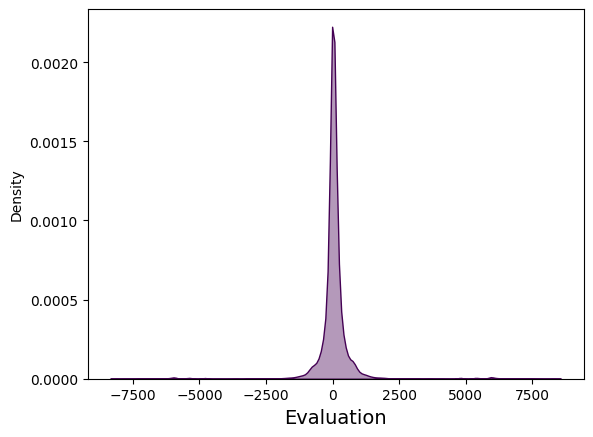

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.kdeplot(df[target], fill=True, alpha=0.4, label = 'KFold', color=sns.color_palette("viridis", as_cmap=True)(0))
plt.xlabel('Evaluation', fontsize=14)
plt.show()

In [27]:
df[target].describe()

count    129581.000000
mean         44.136995
std         798.040891
min       -8125.000000
25%         -68.000000
50%          13.000000
75%         141.000000
max        8345.000000
Name: Evaluation, dtype: float64

It seems that there could be some outliers relative to the target. For instance, let's analyze the position with the highest evaluation.

Evaluation: 8345


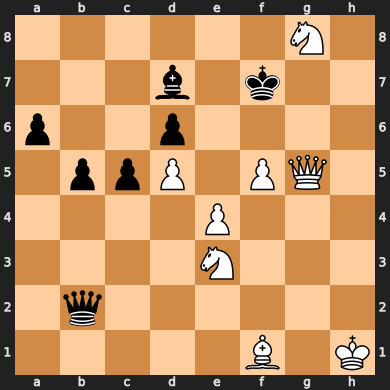

In [40]:
import chess

fen = fens.iloc[df[target].argmax()]
board = chess.Board(fen)

print("Evaluation:",df[target].max())
board

In [41]:
fen

'6N1/3b1k2/p2p4/1ppP1PQ1/4P3/4N3/1q6/5B1K w - - 1 42'

I am not a chess expert, and it's true that black is missing the two knights in this position and 

In [29]:
X.describe()

,White_pieces_count,Black_pieces_count,White_material,Black_material,Material_difference,Turn,White_king_castling,White_queen_castling,Black_king_castling,Black_queen_castling,...,Hanging_pieces_difference,White_passed_pawns,Black_passed_pawns,Passed_pawn_difference,White_king_support,Black_king_support,King_support_difference,White_non_pawn_material,Black_non_pawn_material,Non_pawn_material_difference
count,129581.000000,129581.000000,129581.000000,129581.000000,129581.000000,129581.00000,129581.000000,129581.000000,129581.000000,129581.000000,...,129581.000000,129581.000000,129581.000000,129581.000000,129581.000000,129581.000000,129581.000000,129581.000000,129581.000000,129581.000000
mean,10.372099,10.875746,24.306519,25.790463,-1.483944,-0.00825,0.053040,0.047962,0.057979,0.051265,...,-0.037891,5.222340,5.215194,0.007146,2.026995,2.135915,-0.108920,5080.040693,5489.665452,-409.624760
std,3.551827,3.575705,11.010549,11.135102,3.038095,0.99997,0.224115,0.213687,0.233705,0.220539,...,1.649767,1.779813,1.775592,0.975654,1.106909,1.157367,1.212442,2637.552746,2679.405898,827.260031
min,1.000000,1.000000,0.000000,0.000000,-32.000000,-1.00000,0.000000,0.000000,0.000000,0.000000,...,-7.000000,0.000000,0.000000,-5.000000,0.000000,0.000000,-6.000000,0.000000,0.000000,-8453.000000
25%,8.000000,8.000000,15.000000,16.000000,-3.000000,-1.00000,0.000000,0.000000,0.000000,0.000000,...,-1.000000,4.000000,4.000000,0.000000,1.000000,1.000000,-1.000000,2552.000000,3319.000000,-825.000000
50%,11.000000,11.000000,25.000000,27.000000,-1.000000,-1.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,6.000000,6.000000,0.000000,2.000000,2.000000,0.000000,5420.000000,5808.000000,-374.000000
75%,13.000000,14.000000,34.000000,35.000000,0.000000,1.00000,0.000000,0.000000,0.000000,0.000000,...,1.000000,7.000000,7.000000,0.000000,3.000000,3.000000,1.000000,7477.000000,7521.000000,0.000000
max,18.000000,19.000000,48.000000,51.000000,26.000000,1.00000,1.000000,1.000000,1.000000,1.000000,...,9.000000,8.000000,8.000000,6.000000,6.000000,6.000000,5.000000,10840.000000,11665.000000,7584.000000


In [30]:
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.metrics import r2_score
# clf = RandomForestRegressor()

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# clf.fit(X_train, y_train)
# y_pred = clf.predict(X_train)

# r2_score(y_train, y_pred)

In [31]:
# from sklearn.neural_network import MLPRegressor
# from sklearn.metrics import r2_score
# from sklearn.model_selection import train_test_split

# # Assuming df is already defined and preprocessed
# X, y = df.drop(columns=[target, 'FEN', 'Board', 'Numpy_board']), df[target]

# # Splitting the dataset
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Initialize the MLP Regressor
# mlp = MLPRegressor(hidden_layer_sizes=(100,), max_iter=500, random_state=42)

# # Train the MLP model
# mlp.fit(X_train, y_train)

# # Predict on the training data
# y_train_pred = mlp.predict(X_train)

# # Evaluate the R^2 score
# r2 = r2_score(y_train, y_train_pred)
# print(f"R^2 score on training data: {r2}")


In [32]:
y_pred = clf.predict(X_test)
r2_score(y_test, y_pred)

NameError: name 'clf' is not defined

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

def visualitzaModel(model, X_test ,y_test):
    # Fem PCA per a visualitzar la funció de regressió del model
    pca = PCA(n_components=1)
    carac = pca.fit_transform(X_test).flatten()

    idxs = carac.argsort()
    carac_sorted, y_test_sorted = carac[idxs], np.array(y_test)[idxs]

    # Fem el PCA invers per a fer el plot
    X_test_plot = pca.inverse_transform(np.linspace(carac.min(), carac.max(), 200).reshape(-1, 1))
    y_pred_plot = model.predict(X_test_plot)

    # Fem el plot dels resultats
    plt.figure(figsize=(6, 5))
    plt.scatter(carac_sorted, y_test_sorted, label="Real")
    plt.plot(np.linspace(carac.min(), carac.max(), 200), y_pred_plot, color="red", label="Predicció")
    plt.xlabel("Característiques (PCA 1D)")
    plt.ylabel("Valor Target")
    plt.title("Predicció del Model vs Valors reals")
    plt.legend()
    plt.show()

C:\Users\Albert\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


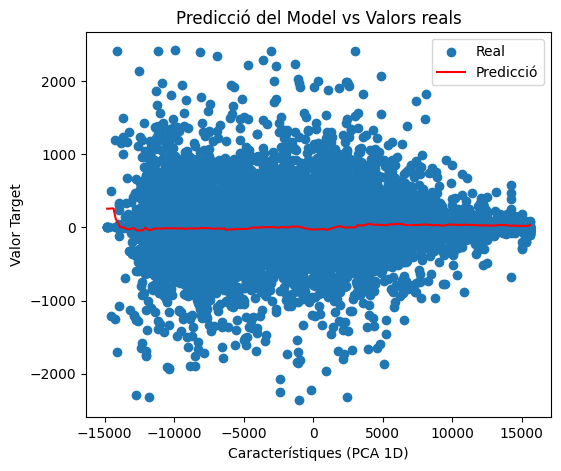

In [ ]:
visualitzaModel(clf, X ,y)

## References

1. [Chess Piece Relative Value - Wikipedia](https://en.wikipedia.org/wiki/Chess_piece_relative_value)
2. [Doubled pawns - Wikipedia](https://en.wikipedia.org/wiki/Doubled_pawn)
3. [Fork (chess) - Wikipedia](https://en.wikipedia.org/wiki/Fork_(chess))
4. [Open file - Wikipedia](https://en.wikipedia.org/wiki/Open_file)